
# <center style="font-family: consolas; font-size: 32px; font-weight: bold;">  Building RAG Application using Mistral LLM & Faiss Vector Database </center>
***


Retrieval-Augmented Generation (RAG) is a technique that enhances large language models (LLMs) by integrating relevant information from external knowledge sources. This approach improves the accuracy and contextual relevance of responses while minimizing the risk of hallucination. In this article, we present a step-by-step guide to building a fully functional RAG application.



<a id="1"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> Getting Started & Setting Up Working Environment </b></div>

The first step in building an RAG application is to prepare the working environment. We will start with downloading the packages we will use in building the application:


In [1]:
%pip install -q -U langchain==0.2.1 torch==2.3.0 transformers==4.41.2 sentence-transformers==3.0.0 datasets==2.19.2 faiss-cpu==1.8.0 langchain-community==0.2.1 bitsandbytes 2>/dev/null

Note: you may need to restart the kernel to use updated packages.


### Next, we will import the packages and libraries that will be used:

In [2]:
import torch
import pandas as pd
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from transformers import AutoTokenizer, pipeline
from langchain import HuggingFacePipeline

2025-05-23 17:35:37.225249: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 17:35:37.225394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 17:35:37.410612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="2"></a>
## Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) enhances large language models (LLMs) by integrating external knowledge sources, enabling them to generate more accurate, context-aware responses and significantly reduce hallucinations.

### Key Components of RAG:

1. **Retrieval:**  
   The retrieval module functions like a search engine, scanning vast text corpora (documents or passages) to find the most relevant information related to the user's query. Advanced retrieval techniques, such as dense passage retrieval, help pinpoint specific text segments aligned with the query’s intent.

2. **Generation:**  
   The LLM receives the retrieved passages as context and leverages its language understanding to craft a comprehensive, accurate answer tailored to the query.

### How RAG Works:

Instead of directly querying the LLM, the user’s question is first converted into a vector embedding—a numerical representation capturing its semantic meaning. This embedding is then matched against a vector database containing precomputed embeddings of the knowledge base. The closest matching documents or passages are retrieved and passed to the LLM as contextual input.

This approach allows:

- **Accurate and Contextual Answers:** By grounding responses in relevant external knowledge.  
- **Reduced Hallucinations:** Because the model relies on real data rather than generating from its internal parameters alone.  
- **Efficient Updates:** New knowledge can be added by updating the vector database, avoiding costly and time-consuming model retraining.

---

### Visual Overview

![RAG Process Diagram](https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/rag-pipeline-ingest-query-flow-b.png)


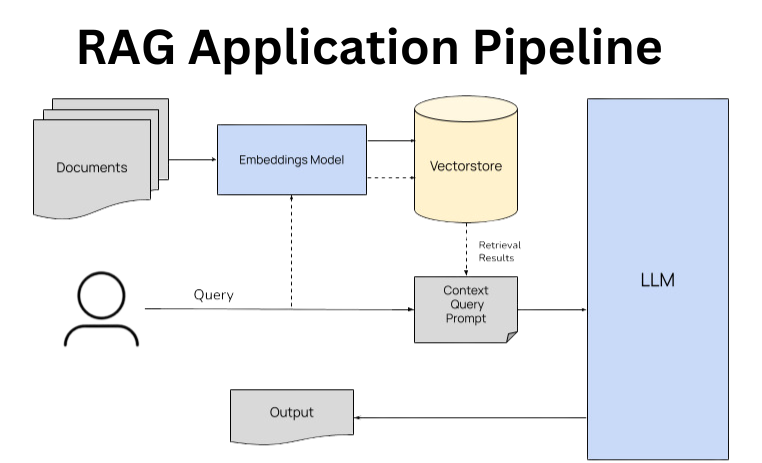

# 🧩 Packages Being Installed

Below is a breakdown of the packages installed in the command:

---

### ✅ `langchain==0.2.1`
- **What it is:** A framework for building applications using large language models (LLMs), especially ones that integrate tools like search, memory, or agents.  
- **Version:** 0.2.1 (Pinned for compatibility and stability)

---

### ✅ `torch==2.3.0`
- **What it is:** PyTorch – a widely used deep learning framework for building and training neural networks.  
- **Version:** 2.3.0 – One of the latest stable releases

---

### ✅ `transformers==4.41.2`
- **What it is:** Hugging Face Transformers – provides thousands of pre-trained NLP models for tasks like text generation, classification, and more.  
- **Version:** 4.41.2 – Recent version with latest model and tokenizer improvements

---

### ✅ `sentence-transformers==3.0.0`
- **What it is:** Library for generating dense sentence embeddings using pre-trained transformer models.  
- **Use case:** Commonly used for semantic search and sentence similarity.

---

### ✅ `datasets==2.19.2`
- **What it is:** Hugging Face Datasets – a hub of preprocessed datasets for machine learning and NLP.  
- **Why used:** Useful for easy dataset loading, preprocessing, and benchmarking.

---

### ✅ `faiss-cpu==1.8.0`
- **What it is:** FAISS (Facebook AI Similarity Search) – a library for efficient similarity search over dense vectors.  
- **CPU version:** Runs without GPU (suitable for local or CPU-based environments).  
- **Use case:** Essential for vector search in RAG systems.

---

### ✅ `langchain-community==0.2.1`
- **What it is:** Extension of `langchain` with community-maintained integrations and tools.  
- **Version:** 0.2.1

---

### ✅ `bitsandbytes`
- **What it is:** A lightweight CUDA library enabling 8-bit quantization for transformer models.  
- **Why used:** Saves memory and improves performance for large model inference, especially on GPUs.

---

### 📌 `2>/dev/null`
- **What it is:** A shell command that redirects error messages to the null device (i.e., hides them).  
- **Why used:** Keeps notebook output clean by suppressing non-critical errors or warnings.

---


In [3]:
data = pd.read_csv('/kaggle/input/grocery-store-dataset/GroceryDataset.csv').dropna().reset_index(drop=True)

In [4]:
def get_description(x):
    return f"""Product title:
{x['Title']}
Product category:
{x['Sub Category']}
Product features:
{x['Feature']}
Product description:
{x['Product Description']}
"""

In [5]:
#getting the full document description:
data['Full Description'] = data.apply(get_description, axis=1)
data.head()

,Sub Category,Price,Discount,Rating,Title,Currency,Feature,Product Description,Full Description
0,Bakery & Desserts,$56.99,No Discount,Rated 4.3 out of 5 stars based on 265 reviews.,"David’s Cookies Mile High Peanut Butter Cake, ...",$,"""10"""" Peanut Butter Cake\nCertified Kosher OU-...",A cake the dessert epicure will die for!Our To...,Product title:\nDavid’s Cookies Mile High Pean...
1,Bakery & Desserts,$159.99,No Discount,Rated 5 out of 5 stars based on 1 reviews.,"The Cake Bake Shop 8"" Round Carrot Cake (16-22...",$,Spiced Carrot Cake with Cream Cheese Frosting ...,"Due to the perishable nature of this item, ord...","Product title:\nThe Cake Bake Shop 8"" Round Ca..."
2,Bakery & Desserts,$44.99,No Discount,Rated 4.1 out of 5 stars based on 441 reviews.,"St Michel Madeleine, Classic French Sponge Cak...",$,100 count\nIndividually wrapped\nMade in and I...,Moist and buttery sponge cakes with the tradit...,"Product title:\nSt Michel Madeleine, Classic F..."
3,Bakery & Desserts,$39.99,No Discount,Rated 4.7 out of 5 stars based on 9459 reviews.,"David's Cookies Butter Pecan Meltaways 32 oz, ...",$,Butter Pecan Meltaways\n32 oz 2-Pack\nNo Prese...,These delectable butter pecan meltaways are th...,Product title:\nDavid's Cookies Butter Pecan M...
4,Bakery & Desserts,$59.99,No Discount,Rated 4.5 out of 5 stars based on 758 reviews.,"David’s Cookies Premier Chocolate Cake, 7.2 lb...",$,"""10"" Four Layer Chocolate Cake\nCertified Kosh...",A cake the dessert epicure will die for!To the...,Product title:\nDavid’s Cookies Premier Chocol...


In [6]:
print(data['Full Description'][0])

Product title:
David’s Cookies Mile High Peanut Butter Cake, 6.8 lbs (14 Servings)
Product category:
Bakery & Desserts
Product features:
"10"" Peanut Butter Cake
Certified Kosher OU-D
14 Servings
Product description:
A cake the dessert epicure will die for!Our Top Selling Cake! Fudge brownie base, layered in velvety smooth peanut butter mousse, rich chocolate cake, topped with brownie chunks, handful of peanut butter chips, drizzled in fudge. This cake is the thoughtful gift idea that’s perfect for family, friends, coworkers, or to anyone you care about in your life. -	Generously sized precut slices, a cake lover’s dreams come true! Includes:Measures 10” diameterWeighs in at 6.8 lbs.14 servings OU-D certified, the most trusted kosher certification in the U.S.All natural with no added preservativesSome of our products may contain nuts. Our facility is NOT a nut-free facility, and as a result it is possible that any product may have come in contact with nut or nut oils



Now that the data is loaded, we need to split the documents inside the data into smaller chunks that can fit into your model's context window.

When you want to deal with long pieces of text, it is necessary to split them into chunks. As simple as this sounds, there is a lot of potential complexity here. Keep the semantically related pieces of text together.

LangChain has many built-in document transformers, making it easy to split, combine, filter, and otherwise manipulate documents. 

<a id="2"></a>
<div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> Generating Embedding with Sentence Transformers Model </b></div>




The next step is to generate embeddings for the loaded and split text. Generating embeddings is an essential step for building an RAG application as they encode semantic information about text, facilitating understanding of meaning and context crucial for both retrieval and generation processes which enhance retrieval accuracy by comparing query and document embeddings.

We will use the [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) embedding model from the [SentenceTransformers](https://www.sbert.net/) to generate the embeddings. First, we will initialize it using the code below:


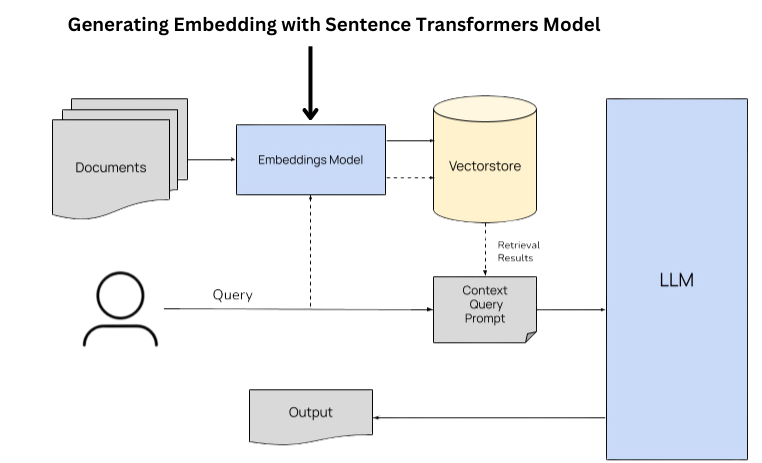

In [7]:
modelPath = "sentence-transformers/all-MiniLM-l6-v2"
model_kwargs = {'device':0}
encode_kwargs = {'normalize_embeddings': False}

embedder = HuggingFaceEmbeddings(
    model_name=modelPath, 
    model_kwargs=model_kwargs, 
    encode_kwargs=encode_kwargs 
)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
from langchain_community.document_loaders import DataFrameLoader

def get_documents(data, page_content_column):
    return DataFrameLoader(data, page_content_column=page_content_column).load()

documents = get_documents(data, 'Full Description')
documents2 = get_documents(data, 'Product Description')
print(f'We have {len(documents)} context in total\n')

We have 673 context in total



In [9]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# CHUNK_SIZE = 2000
# OVERLAP = 50      
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size = CHUNK_SIZE,
#     chunk_overlap = OVERLAP
# )
# texts = text_splitter.split_documents(documents)
# print(f'We have created {len(texts)} chunks from {len(documents)} context')

Once we generate the embeddings we will need them stored in a vector database. Vector databases support indexing and clustering techniques optimized for high-dimensional data like embeddings, which can further improve retrieval efficiency and accuracy. We will use the Faiss vector database to save our embeddings.

<a id="3"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b> Store the Embeddings in the Faiss Vector Database </b></div>


The embeddings are generated, but we need them to be stored in a vector database. We’ll be saving those embeddings in the FAISS vector store, which is a library for efficient similarity search and clustering dense vectors.


In [10]:
query = "Cookies Mile High Peanut Butter Cake"
db2 = FAISS.from_documents(documents2, embedder)
db2.similarity_search(query, k=1)

[Document(metadata={'Sub Category': 'Bakery & Desserts', 'Price': '$39.99 ', 'Discount': 'No Discount', 'Rating': 'Rated 4.3 out of 5 stars based on 845 reviews.', 'Title': 'David’s Cookies Decadent Triple Chocolate made with mini Hershey’s Kisses and Reese’s Peanut Butter Cup Cookies Tin – 2 Count', 'Currency': '$', 'Feature': '8 Jumbo Triple Chocolate made with mini Hershey’s Kisses\n8 Jumbo Reese’s Peanut Butter Cup Cookies\nKosher OU-D certified', 'Full Description': "Product title:\nDavid’s Cookies Decadent Triple Chocolate made with mini Hershey’s Kisses and Reese’s Peanut Butter Cup Cookies Tin – 2 Count\nProduct category:\nBakery & Desserts\nProduct features:\n8 Jumbo Triple Chocolate made with mini Hershey’s Kisses\n8 Jumbo Reese’s Peanut Butter Cup Cookies\nKosher OU-D certified\nProduct description:\nDue to the perishable nature of this product orders will only ship on Monday and Tuesday for Thursday and Friday delivery. Orders will not ship over the weekend. Orders placed a

In [11]:
db = FAISS.from_documents(documents, embedder)
db.similarity_search(query, k=1)

[Document(metadata={'Sub Category': 'Bakery & Desserts', 'Price': '$56.99 ', 'Discount': 'No Discount', 'Rating': 'Rated 4.3 out of 5 stars based on 265 reviews.', 'Title': 'David’s Cookies Mile High Peanut Butter Cake, 6.8 lbs (14 Servings)', 'Currency': '$', 'Feature': '"10"" Peanut Butter Cake\nCertified Kosher OU-D\n14 Servings', 'Product Description': 'A cake the dessert epicure will die for!Our Top Selling Cake! Fudge brownie base, layered in velvety smooth peanut butter mousse, rich chocolate cake, topped with brownie chunks, handful of peanut butter chips, drizzled in fudge. This cake is the thoughtful gift idea that’s perfect for family, friends, coworkers, or to anyone you care about in your life. -\tGenerously sized precut slices, a cake lover’s dreams come true! Includes:Measures 10” diameterWeighs in at 6.8 lbs.14 servings OU-D certified, the most trusted kosher certification in the U.S.All natural with no added preservativesSome of our products may contain nuts. Our facil

<a id="4"></a>
# <div style="box-shadow: rgba(0, 0, 0, 0.16) 0px 1px 4px inset, rgb(51, 51, 51) 0px 0px 0px 3px inset; padding:20px; font-size:32px; font-family: consolas; text-align:center; display:fill; border-radius:15px;  color:rgb(34, 34, 34);"> <b>  Querying Answers from the RAG Application </b></div>




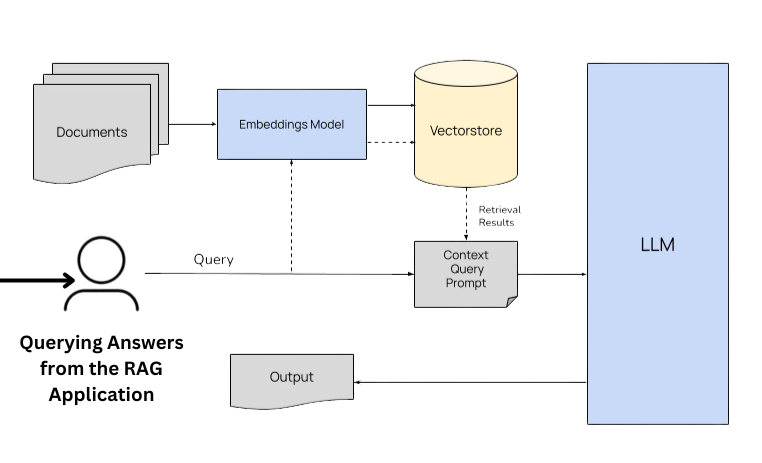

The final step is to generate the answers using both the vector store and the LLM. It will generate embeddings to the input query or question retrieve the context from the vector store, and feed this to the LLM to generate the answers:

In [12]:
from langchain_community.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import transformers


model_id = "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1"
bnb_config = transformers.BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_use_double_quant=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_compute_dtype=torch.bfloat16
)
model = transformers.AutoModelForCausalLM.from_pretrained(
  model_id,
  trust_remote_code=True,
  quantization_config=bnb_config,
  device_map='cuda',
)

tokenizer = transformers.AutoTokenizer.from_pretrained(
  model_id,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
pipe = pipeline(
    "text-generation", model=model, tokenizer=tokenizer, max_new_tokens=200
)
hf = HuggingFacePipeline(pipeline=pipe)

/tmp/ipykernel_26/707667238.py:4: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from rom langchain-huggingface package and should be used instead. To use it run `pip install -U from rom langchain-huggingface` and import as `from from rom langchain_huggingface import llms import HuggingFacePipeline`.
  hf = HuggingFacePipeline(pipeline=pipe)


### Finally lets pass it a question and try it

In [14]:
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain
from langchain.chains import RetrievalQA

prompt_template = """
### [INST] Instruction: Answer the question based on the context provided below. 
Here is context to help:

{context}

### QUESTION:
{question} [/INST]
 """

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

llm_chain = LLMChain(llm=hf, prompt=prompt)

rag_chain = ( 
 {"context": db.as_retriever(), "question": RunnablePassthrough()}
    | llm_chain
)

def parse_mistral_answer(answ):
    return answ['text'].split('[/INST]')[1].strip() if len(answ['text'].split('[/INST]')) > 1 else None

/tmp/ipykernel_26/3353732392.py:22: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  llm_chain = LLMChain(llm=hf, prompt=prompt)


In [15]:
print(parse_mistral_answer(rag_chain.invoke("Tell me about David's Cookies Butter Pecan Meltaways")))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


David's Cookies Butter Pecan Meltaways are a baked good that is part of the "Bakery & Desserts" category. They are a type of cookie that is made with butter and pecans, and have just the right amount of powdered sugar to satisfy your sweet tooth. The cookies are made with pure creamy butter and large pecan chunks, and are packaged in a 2-pack of tins that are 32 oz each. They are certified kosher by the Orthodox Union (OU-D), and contain nuts. The cookies can be stored at room temperature for up to 60 days, and each tin contains approximately 64 cookies.


In [16]:
print(parse_mistral_answer(rag_chain.invoke("What is the price of David’s Cookies Mile High Peanut Butter Cake?")))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The price of David’s Cookies Mile High Peanut Butter Cake is $56.99.


In [17]:
print(parse_mistral_answer(rag_chain.invoke("What is the rating of David’s Cookies Premier Chocolate Cake?")))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The rating of David's Cookies Premier Chocolate Cake is 4.5 out of 5 stars based on 758 reviews.


In [18]:
print(parse_mistral_answer(rag_chain.invoke("List top products under the Beverages & Water category. Show only names")))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1. Ready Sports Drink Light, Mango Lemonade, 16.9 fl oz, 12-count
 2. Joyburst Energy Variety, 12 fl oz, 18-count
 3. Joyburst Energy Drink, Frose Rose, 12 fl oz, 12-count
 4. 100% Spring Water, 2.5 Gallon, 2-count, 48 Case Pallet


In [19]:
print(parse_mistral_answer(rag_chain.invoke("List products under the Beverages & Water category. Show names and prices")))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1. Ready Sports Drink Light, Mango Lemonade, 16.9 fl oz, 12-count - $24.99
 2. Pure Vanilla Extract, 16 fl oz - $16.99
 3. 100% Spring Water, 2.5 Gallon, 2-count, 48 Case Pallet - $549.99


In [20]:
print(parse_mistral_answer(rag_chain.invoke("Is there any Kosher desserts I can buy?")))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Yes, there are Kosher desserts available. David's Cookies Premier Chocolate Cake and David's Cookies Mile High Peanut Butter Cake are both certified Kosher OU-D.


In [21]:
print(parse_mistral_answer(rag_chain.invoke('Do we have any ice-cream?')))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The context provided does not mention any ice cream.
